# VGG Transfer Learning

### Setting Up the Project Directory

In [1]:
%cd /content/drive/MyDrive/Datasets/Flowers Dataset

/content/drive/MyDrive/Datasets/Flowers Dataset


### Imports

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import json
import os

### Transformation for Train & Test Set

In [3]:
# Define transformations for training and validation sets
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

### Loading the Dataset with Dataloaders

In [4]:
# Load the Flowers dataset
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Datasets/Flowers Dataset/train', transform=transform['train'])
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Datasets/Flowers Dataset/test', transform=transform['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Pretrained Model Loading

In [5]:
# Load a pretrained VGG-16 model
model = models.vgg16(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier to train only the last layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(train_dataset.classes))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 118MB/s]


### Setting Up the Loss & Optimizer

In [6]:
from torchsummary import summary

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Define the Training Loop with Validation

In [7]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []
    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model checkpoint saved!")

    return train_losses, val_losses, val_accuracies

### Start Training

Epoch 1/2, Train Loss: 0.2727, Val Loss: 0.1536, Val Acc: 0.9451
Model checkpoint saved!
Epoch 2/2, Train Loss: 0.1953, Val Loss: 0.1656, Val Acc: 0.9286


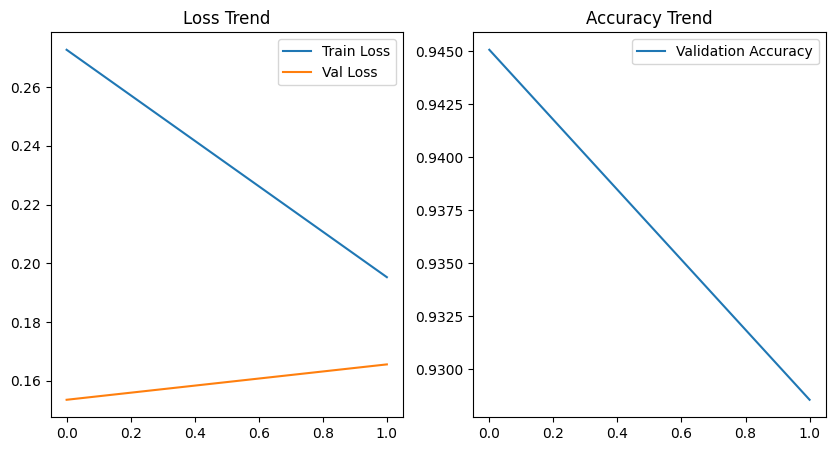

In [8]:
# Train the model
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)

# Plot accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Trend')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Trend')
plt.show()

### Load the trained Model & Evalaute

<ipython-input-9-d1c0a029bf26>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


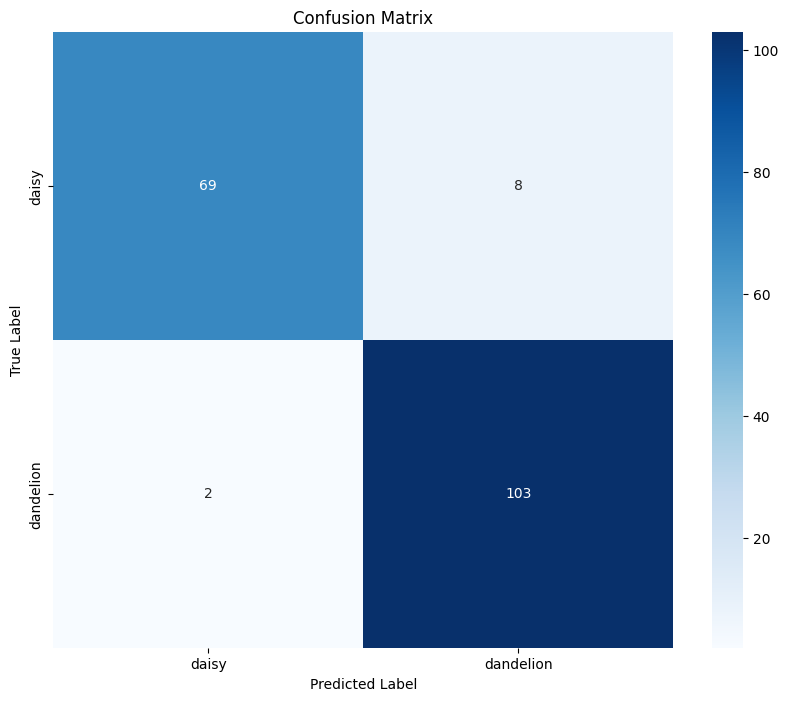

In [9]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Confusion matrix visualization
def plot_confusion_matrix(model, dataloader):
    from sklearn.metrics import confusion_matrix
    import pandas as pd

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, val_loader)

### Model Inferencing

In [10]:
# Inference function
def infer(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform['test'](image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # Get the top k probabilities, where k is the minimum between 5 and the number of classes
    k = min(5, probabilities.size(0))  # Ensure k is within the valid range
    top5_prob, top5_catid = probabilities.topk(k)
    results = [(train_dataset.classes[catid], prob.item()) for catid, prob in zip(top5_catid, top5_prob)]
    return results

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(image_path):
    image = Image.open(image_path)  # Open the image using PIL
    plt.imshow(image)  # Display the image
    plt.axis("off")  # Hide axes for better visualization
    plt.show()  # Show the image in the notebook

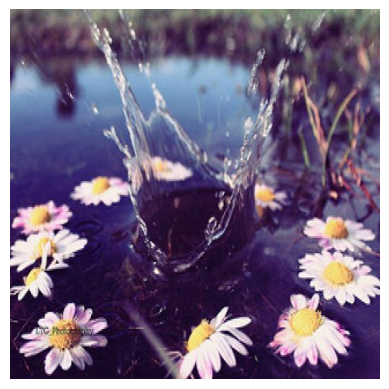

daisy: 0.8249
dandelion: 0.1751


In [12]:
# Example usage
image_path = "/content/drive/MyDrive/Datasets/Flowers Dataset/train/daisy/10172379554_b296050f82_n_jpg.rf.ab8f14fde6cdbc0851b8a238b4e73c36.jpg"  # Replace with your image path
show_image(image_path)
results = infer(image_path, model)
for label, prob in results:
    print(f"{label}: {prob:.4f}")